<h1>Developing a Feature Space fo a MultiLabel CNN Model<h1>

In [ ]:
from sklearn.metrics import classification_report, jaccard_score, hamming_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
from umap import UMAP
from keras import Model
from keras.utils import plot_model

In [ ]:
# Importing user-defined modules
from Scripts.ptbxl_ml import *
from Scripts.lead2_ml import *
from Scripts.lead2_mc import get_cluster_accuracy as mc_cluster_acc

<h3>Loading and Pre-Processing Data:</h3>

In [ ]:
npz_file = r'C:\Users\loera\OneDrive\Python Projects\College\ECG\Processed Datasets\ML_dataset.npz'

In [198]:
ptbxl_df, signals_df = load_database(npz_file)

In [199]:
# Assigning signals as the data and superclasses as the labels
X = signals_df
Y = ptbxl_df.loc[:, 'superclasses'].convert_dtypes()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [200]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(17110, 5000) (17110,)
(4278, 5000) (4278,)


In [201]:
# Converting labels into binary matrix format
y_train, y_test, label_classes = ml_label_encoding(y_train, y_test)

In [202]:
y_train

array([[1, 1, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0]])

<h3>Loading Model and Extracting Features:</h3>

In [203]:
def load_model(checkpoint_path: str, model_type='a') -> keras.Sequential:
    '''
    Loads and returns a CNN model using pre-defined weights. The model generated and compiled is determined by the model 
    architecture specified for the 'model_type' argument.
    
    Args:
        checkpoint_path: The path containing the pre-definded weights
        model_type: The type of model architecture to compile
        
    Returns:
        keras.Sequential: The compiled model
    '''
    # Generates a model using the article architecture
    if model_type == 'a':
        model = generate_article_1D_model()
    
    # Generates a model with using the default architecture
    elif model_type == 'd':
        model = generate_default_1D_model()
    
    # Loads best weights from training session
    model.load_weights(checkpoint_path)
    
    # Compiles model with similar hyperparametes as pre-trained model
    model.compile(loss = keras.losses.BinaryCrossentropy(),
                  optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.009, beta_2=0.8, epsilon=1e-08),
                  metrics = [keras.metrics.BinaryAccuracy(name='Accuracy'),
                             keras.metrics.Recall(name='Recall'),
                             keras.metrics.Precision(name='Precision'),
                             keras.metrics.AUC(name='AUC')])
    
    return model

In [204]:
def extract_features(checkpoint_path: str, test_data: pd.DataFrame, model_type: str='a', show_summary: bool=True) -> np.ndarray:
    '''
    Extracts feature representations of a pre-trained model using validation data. The output (final) layer is removed from the 
    model in order to return the feature embeddings from the penultimate layer.
    
    Args:
        checkpoint_path: The path containing the weights to load into the generated model
        test_data: DataFrame containing the ECG signals corresponding to the testing/validation set
        model_type: Specifies which model architecture to load
        show_summary: Boolean value that determines if the new model architecture will be displayed
        
    Returns:
        np.ndarray: A matrix containing feature embeddings from the penultimate layer
    '''
    # Loading model of specified architecture
    model = load_model(checkpoint_path=checkpoint_path, model_type=model_type)
    
    # Removing the final layer and printing architecture of the model
    model.pop()
    
    if show_summary:
        model.summary()
   
    # Predicts and extracts the features
    feature_embeddings = model.predict(test_data)
    
    return feature_embeddings

In [205]:
# Model with article architecture
checkpoint_path = r'Training Sessions\Article Multilabel\Training Session 2\CustomCNN_Lead2_60.weights.h5'

In [206]:
feature_embeddings = extract_features(checkpoint_path, x_test)

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 4998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 4998, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling1D)             │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 2499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 2497, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 2497, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 2497, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling1D)             │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1246, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 1246, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 1246, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling1D)             │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 623, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv1D)                  │ (None, 621, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 621, 256)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (Activation)              │ (None, 621, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max4 (MaxPooling1D)             │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop4 (Dropout)                 │ (None, 310, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv1D)                  │ (None, 308, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 308, 512)       │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu5 (Activation)              │ (None, 308, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max5 (MaxPooling1D)             │ (None, 154, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop5 (Dropout)                 │ (None, 154, 512)       │             

 Total params: 8,406,976 (32.07 MB)

 Trainable params: 8,398,848 (32.04 MB)

 Non-trainable params: 8,128 (31.75 KB)

134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step


<h3>Generating Predictions:</h3>

In [207]:
# Loading new model with complete article architecture
model_1 = load_model(checkpoint_path)

In [208]:
y_test, y_hat = model_predict(model=model_1,
                              test_data=x_test,
                              test_labels=y_test)

134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step


In [209]:
print('Predictions:\n', y_hat)
print('\nTrue Labels:\n', y_test)
print('\nShape:', y_hat.shape)

Predictions:
 [[1 0 0 1 0]
 [0 0 0 0 0]
 [1 0 1 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]

True Labels:
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 1 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]

Shape: (4278, 5)


<h3>Computing Confusion Matrix:</h3>

In [210]:
# Utilizing the class labels extracted from the label encoding for the confusion matrix labels
matrix_labels = label_classes

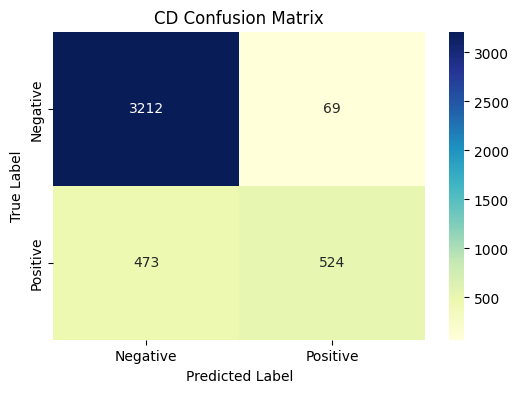

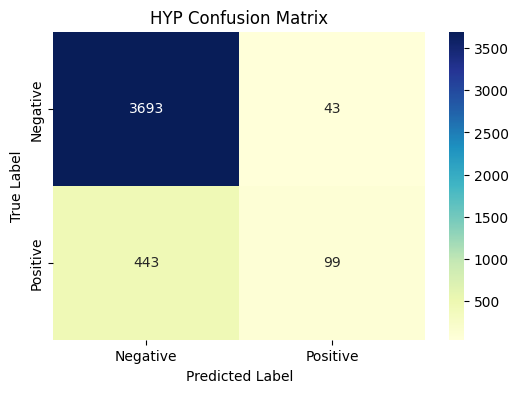

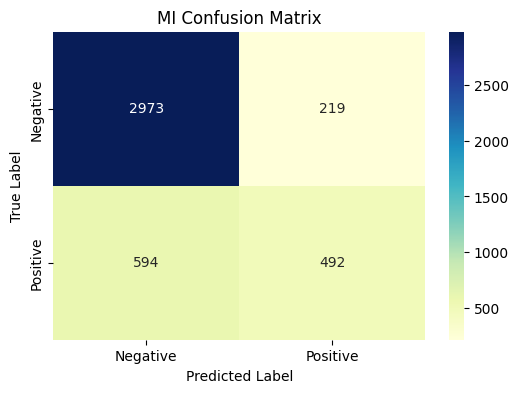

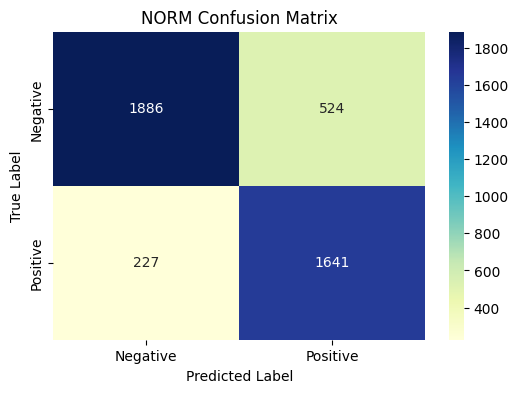

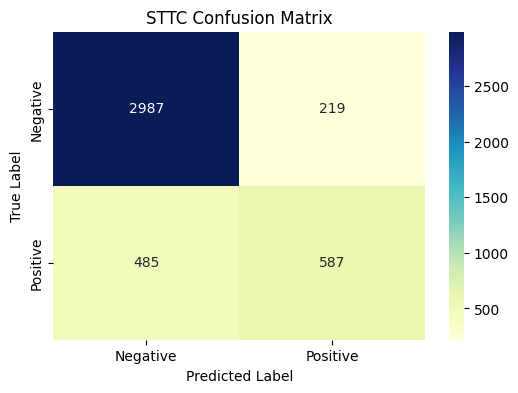

In [211]:
conf_matrix = show_confusion_matrix(y_test, y_hat, classes=matrix_labels) 

<h3>Displaying Classification Report:</h3>

In [212]:
def error_indices_report(true_labels: np.ndarray, pred_labels: np.ndarray, class_to_check: int) -> np.ndarray:
    '''
    Returns the indices where a false negative was computed for the specified class.
    
    Args:
        true_labels: The ground truth labels
        pred_labels: The predicted labels generated by a pre-trained model
        class_to_check: The class that's being checked for false negatives
    
    Returns:
        np.ndarray: An array containing the indices of all the false negatives computed for the specified class
    '''
    error_indices = np.where((true_labels[:, class_to_check] == 1) & (pred_labels[:, class_to_check] != 1))[0]
    
    return error_indices

In [213]:
y_test

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [214]:
# Computing the error indices for all classes
CD_error_indices = error_indices_report(y_test, y_hat, 0)
HYP_error_indices = error_indices_report(y_test, y_hat, 1)
MI_error_indices = error_indices_report (y_test, y_hat, 2)
NORM_error_indices = error_indices_report(y_test, y_hat, 3)
STTC_error_indicees = error_indices_report(y_test, y_hat, 4)

In [215]:
print('\nClassification Report:\n')
print(classification_report(y_test, y_hat, target_names=['CD', 'HYP', 'MI', 'NORM', 'STTC']))

print('False Negative CD Classifications:', len(CD_error_indices))
print('False Negative HYP Classifications:', len(HYP_error_indices))
print('False Negative MI Classifications:', len(MI_error_indices))
print('False Negative NORM Classifications:', len(NORM_error_indices))
print('False Negative STTC Classifications:', len(STTC_error_indicees))


Classification Report:

              precision    recall  f1-score   support

          CD       0.88      0.53      0.66       997
         HYP       0.70      0.18      0.29       542
          MI       0.69      0.45      0.55      1086
        NORM       0.76      0.88      0.81      1868
        STTC       0.73      0.55      0.63      1072

   micro avg       0.76      0.60      0.67      5565
   macro avg       0.75      0.52      0.59      5565
weighted avg       0.76      0.60      0.65      5565
 samples avg       0.69      0.65      0.65      5565

False Negative CD Classifications: 473
False Negative HYP Classifications: 443
False Negative MI Classifications: 594
False Negative NORM Classifications: 227
False Negative STTC Classifications: 485


c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<h3>K-Means Clustering:</h3>

In [216]:
def display_class_clusters(feature_embeddings: np.ndarray, dim_red: str='p') -> np.ndarray:
    '''
    Returns clustered superclasses from the PTB-XL database based on the feature embeddings provided. 
    Clusters are computed via K-Means clustering.
    
    Args:
        feature_embeddings: The feature embeddings to be clustered
        dim_red: The dimensionality reduction to use when visualing clusters ('p'= PCA, 't'= TSNE, 'u'= UMAP)
        
    Returns:
        np.ndarray: An array containing the assigned cluster label for each record/data point
    '''
    # Grouping extracted features into clusters and storing associated labels for all records
    kmeans = KMeans(n_clusters=5, random_state=42).fit(feature_embeddings)
    labels = kmeans.labels_
    
    # Organzing data into a DataFrame
    clusters = pd.DataFrame(data=labels, columns=['Cluster'])
    
    # Reducing data to two-dimensional feature space using the specified reduction technique
    if dim_red == 'p':
        pca = PCA(n_components=2, random_state=42)
        data = pca.fit_transform(feature_embeddings)
        col_names = ['pca1', 'pca2']
        
    elif dim_red == 't':
        tsne = TSNE(n_components=2, random_state=42)
        data = tsne.fit_transform(feature_embeddings)
        col_names = ['tsne1', 'tsne2']
    
    elif dim_red == 'u':    
        umap = UMAP(n_components=2, random_state=42)
        data = umap.fit_transform(feature_embeddings)
        col_names = ['umap1', 'umap2']

    # Storing reduced data into a DataFrame and plotting the clusters
    results = pd.DataFrame(data=data, columns=col_names) 
    sns.scatterplot(x=col_names[0],
                    y=col_names[1],
                    hue=clusters['Cluster'],
                    data=results)
    
    plt.title('K-Means Clusters')
    plt.show()
    return labels

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


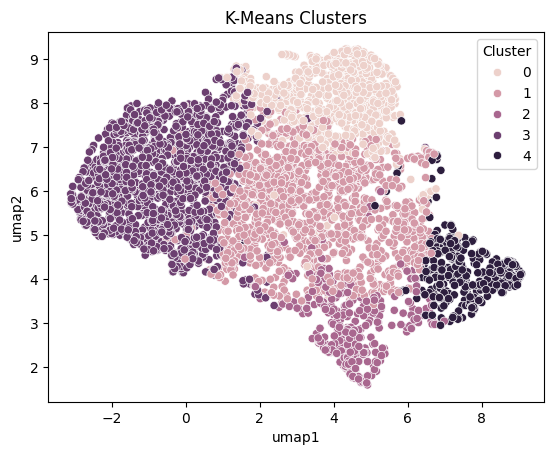

In [217]:
class_cluster_labels = display_class_clusters(feature_embeddings, dim_red='u')

<h3>Clustering Based on Metadata:</h3>

In [218]:
def get_metadata_feature(ptbxl_database: pd.DataFrame, train_data: pd.DataFrame, test_data: pd.DataFrame, feature: str, remove_na: bool=True, min_threshold: int | None=None, max_threshold: int | None=None) -> tuple[pd.Series, pd.Series]:
    '''
    Retrieves a specific feature from the PTB-XL database and returns both training and testing labels as Pandas Series. Removes any missing 
    values by default and can additionally remove any values below or above a specified threshold.
    
    Args:
        ptbxl_database: The DataFrame containing all the PTB-XL metadata
        train_data: The ECG signals corresponding to the train dataset
        test_data: The ECG signals corresponding to the test/validation dataset
        feature: The feature/attribute within 'ptbxl_database' that is being retrieved (e.g., age, height)
        remove_na: Boolean value that determines if missing values will be removed
        min_threshold: If specified, removes any records holding a value less than the threshold
        max_threshold: If specified, removes any records holding a value larger than the threshold
        
    Returns:
        tuple: A two-element tuple (training and testing set) containing the labels for the specified feature
    '''
    # Retrieving record indices corresponding to both training and validation datasets
    train_indices = train_data.index
    test_indices = test_data.index
    
    # Acquiring labels corresponding to specified feature
    train_labels = ptbxl_database.loc[train_indices, feature].convert_dtypes()
    test_labels = ptbxl_database.loc[test_indices, feature].convert_dtypes()
    
    train_length = len(train_labels)
    test_length = len(test_labels)
    
    if remove_na:
        # Finding empty records
        na_train_labels = pd.isna(train_labels)
        na_test_labels = pd.isna(test_labels)
        
        # Keeping non-empty records
        train_labels = train_labels[~(na_train_labels)]
        test_labels = test_labels[~(na_test_labels)]
        
        print(f'Removed {train_length - len(train_labels)} records with missing values from training set')
        print(f'Removed {test_length - len(test_labels)} records with missing values from testing set')
        
        # Updating length of both datasets
        train_length = len(train_labels)
        test_length = len(test_labels)
        
    if min_threshold:
        # Removing values below minimum threshold
        train_bool_mask = (train_labels >= min_threshold)
        test_bool_mask = (test_labels >= min_threshold)
        
        train_labels = train_labels[train_bool_mask]
        test_labels = test_labels[test_bool_mask]
        
        print('\n')
        print(f'Removed {train_length - len(train_labels)} records below threshold from training set')
        print(f'Removed {test_length - len(test_labels)} records below threshold from testing set')
        
        # Updating length of both datasets
        train_length = len(train_labels)
        test_length = len(test_labels)
        
    if max_threshold:
        # Removing values above max threshold
        train_bool_mask = (train_labels <= max_threshold)
        test_bool_mask = (test_labels <= max_threshold)
        
        train_labels = train_labels[train_bool_mask]
        test_labels = test_labels[test_bool_mask]
        
        print('\n')
        print(f'Removed {train_length - len(train_labels)} records above threshold from training set')
        print(f'Removed {test_length - len(test_labels)} records above threshold from testing set')
        
        # Updating length of both datasets
        train_length = len(train_labels)
        test_length = len(test_labels)
    
    train_labels_df = pd.Series(data=train_labels, index=train_labels.index)
    test_labels_df = pd.Series(data=test_labels, index=test_labels.index)
    
    return (train_labels_df, test_labels_df)

In [219]:
# Retrieving age metadata
age_train_df, age_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'age', min_threshold=2)

Removed 0 records with missing values from training set
Removed 0 records with missing values from testing set


Removed 0 records below threshold from training set
Removed 0 records below threshold from testing set


In [220]:
# Retrieving sex metadata
sex_train_df, sex_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'sex')

Removed 0 records with missing values from training set
Removed 0 records with missing values from testing set


In [221]:
# Retrieving height metadata
height_train_df, height_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'height', min_threshold=60)

Removed 11600 records with missing values from training set
Removed 2870 records with missing values from testing set


Removed 3 records below threshold from training set
Removed 0 records below threshold from testing set


In [222]:
# Retrieving weight metadata
weight_train_df, weight_test_df = get_metadata_feature(ptbxl_df, x_train, x_test, 'weight', min_threshold=5)

Removed 9588 records with missing values from training set
Removed 2434 records with missing values from testing set


Removed 0 records below threshold from training set
Removed 0 records below threshold from testing set


In [223]:
def get_metadata_buckets(train_metadata: pd.DataFrame | pd.Series, test_metadata: pd.DataFrame | pd.Series, buckets: int| list) -> tuple[pd.Series, pd.Series, np.ndarray]:
    '''
    Groups metadata into ordered buckets (i.e. categorically labeled groups).
    
    Args:
        train_metadata: The DataFrame or Series holding the labels from the training set
        test_metadata: The DataFrame or Series holding the labels from the testing/validation set        
        buckets: As an integer, creates n equally sized buckets. As a list, uses list values as the ranges for each bucket
    
    Returns:
        Tuple: A three-element tuple containing: Training buckets, testing buckets, intervals used to create buckets
    '''
    if type(buckets) == int:
        # Creating training buckets
        train_buckets_df, train_bins = pd.cut(train_metadata,
                                              bins=buckets,
                                              labels=list(range(buckets)),
                                              retbins=True)
        
        # Creating testing buckets
        test_buckets_df = pd.cut(test_metadata,
                                 bins=train_bins,
                                 labels=list(range(buckets)))
        
    elif type(buckets) == list:
        # Creating training buckets
        train_buckets_df, train_bins = pd.cut(train_metadata,
                                              bins=buckets,
                                              labels=list(range(len(buckets) - 1)),
                                              retbins=True,
                                              include_lowest=True)
        
        # Creating testing buckets
        test_buckets_df = pd.cut(test_metadata,
                                 bins=buckets,
                                 labels=list(range(len(buckets) - 1)),
                                 include_lowest=True)
    
    # Printing bucket labels and their intervals
    print(f'Bucket Intervals:\n')
    for i in range((len(train_bins) - 1)):
        if i == 0:
            print(f'Bucket {i}: [{train_bins[i]}, {train_bins[i+1]}]')
        else:
            print(f'Bucket {i}: ({train_bins[i]}, {train_bins[i+1]}]')
                
    return (train_buckets_df, test_buckets_df, train_bins)

In [224]:
age_buckets = [2, 25, 50, 75, np.inf]
age_train_labels, age_test_labels, age_bucket_intervals = get_metadata_buckets(age_train_df, age_test_df, buckets=age_buckets)

Bucket Intervals:

Bucket 0: [2.0, 25.0]
Bucket 1: (25.0, 50.0]
Bucket 2: (50.0, 75.0]
Bucket 3: (75.0, inf]


In [225]:
height_buckets = [60, 100, 133, 166, np.inf]
height_train_labels, height_test_labels, height_bucket_intervals = get_metadata_buckets(height_train_df, height_test_df, buckets=height_buckets)

Bucket Intervals:

Bucket 0: [60.0, 100.0]
Bucket 1: (100.0, 133.0]
Bucket 2: (133.0, 166.0]
Bucket 3: (166.0, inf]


In [226]:
weight_buckets = [5, 60, 120, 180, np.inf]
weight_train_labels, weight_test_labels, weight_bucket_intervals = get_metadata_buckets(weight_train_df, weight_test_df, buckets=weight_buckets)

Bucket Intervals:

Bucket 0: [5.0, 60.0]
Bucket 1: (60.0, 120.0]
Bucket 2: (120.0, 180.0]
Bucket 3: (180.0, inf]


In [227]:
# Creating feature embeddings specific to each metadata feature
age_test_indices = age_test_df.index
age_feature_embeddings = extract_features(checkpoint_path, x_test.loc[age_test_indices], show_summary=False)

sex_test_indices = sex_test_df.index
sex_feature_embeddings = extract_features(checkpoint_path, x_test.loc[sex_test_indices], show_summary=False)

height_test_indices = height_test_df.index
height_feature_embeddings = extract_features(checkpoint_path, x_test.loc[height_test_indices], show_summary=False)

weight_test_indices = weight_test_df.index
weight_feature_embeddings = extract_features(checkpoint_path, x_test.loc[weight_test_indices], show_summary=False)

134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step


In [228]:
def display_metadata_clusters(metadata: pd.Series, feature_embeddings: np.ndarray, bucket_intervals: np.ndarray | None=None, dim_red: str='u'):
    '''
    Clusters feature embeddings via K-Means using the number of buckets/groups found in the data. The provided metadata should be
    labeled according to its bucket group and consist of one of the features found within the PTB-XL database.
    
    Args:
        metadata: The metadata (e.g., age, height) that will be used to cross-check the clustered feature embeddings
        feature_embeddings: The feature embeddings that will be clustered
        bucket_intervals: An array containing the ranges of all buckets regarding the metadata
        dim_red: The dimensionality reduction to use when visualing clusters ('p'= PCA, 't'= TSNE, 'u'= UMAP)
        
    Returns:
        np.ndarray: An array containing the assigned cluster labels for each record/data point
    '''
    # Retrieving the number of clusters
    try:
        n_clusters = len(bucket_intervals) - 1
    except TypeError:
        n_clusters = 2
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(feature_embeddings)
    cluster_labels = kmeans.labels_
    
    # Reducing feature embeddings to a two-dimensional feature space using the specified reduction technique
    if dim_red == 'p':
        pca = PCA(n_components=2, random_state=42)
        data = pca.fit_transform(feature_embeddings)
        col_names = ['pca1', 'pca2']
        
    elif dim_red == 't':
        tsne = TSNE(n_components=2, random_state=42)
        data = tsne.fit_transform(feature_embeddings)
        col_names = ['tsne1', 'tsne2']
    
    elif dim_red == 'u':    
        umap = UMAP(n_components=2, random_state=42)
        data = umap.fit_transform(feature_embeddings)
        col_names = ['umap1', 'umap2']
    
    # Storing transformed data into a DataFrame and plotting the clusters
    column_name = metadata.name.capitalize()
   
    results = pd.DataFrame(data=data, columns=col_names)
    results[f'{column_name} Group'] = metadata.reset_index(drop=True)
    results['Cluster'] = cluster_labels
    
    sns.scatterplot(x=col_names[0],
                    y=col_names[1],
                    hue=results['Cluster'],
                    style=results[f'{column_name} Group'],
                    data=results)
    plt.title(f'K-Means Clusters vs. {column_name}')
    plt.show()
    
    return cluster_labels

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


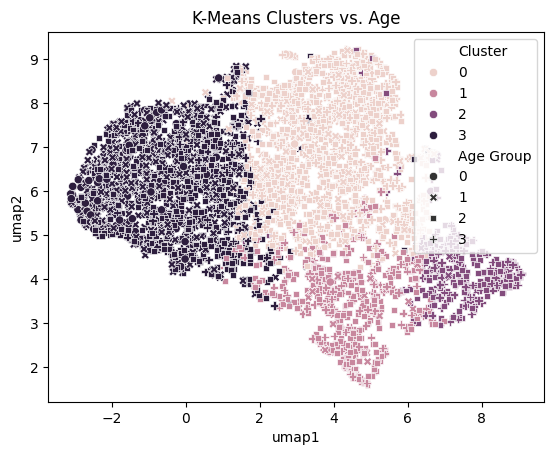

In [229]:
age_cluster_labels = display_metadata_clusters(age_test_labels, age_feature_embeddings, age_bucket_intervals)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


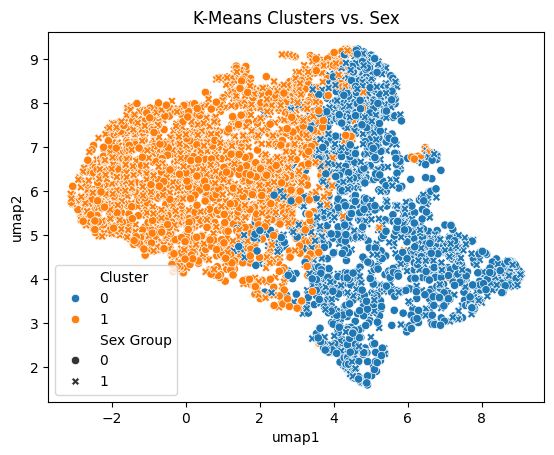

In [230]:
sex_cluster_labels = display_metadata_clusters(sex_test_df, sex_feature_embeddings)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


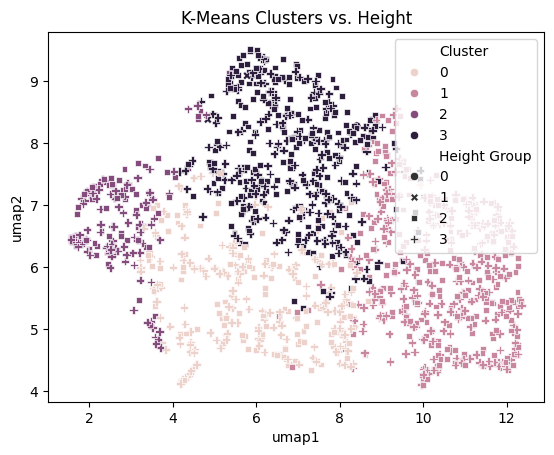

In [231]:
height_cluster_labels = display_metadata_clusters(height_test_labels, height_feature_embeddings, height_bucket_intervals)

c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


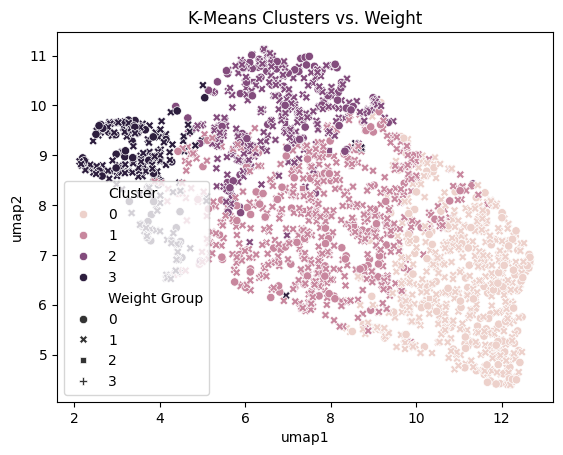

In [232]:
weight_cluster_labels = display_metadata_clusters(weight_test_labels, weight_feature_embeddings, weight_bucket_intervals)

<h3>Evaluating Clustering Accuracy:</h3>

In [233]:
def get_cluster_accuracy(test_labels: pd.DataFrame | pd.Series | np.ndarray, cluster_labels: np.ndarray, n_classes: int) -> dict:
    '''
    Determines the accuracy between the ground truth labels and the assigned cluster labels using a two-method approach. The first
    method creates prototypical vectors for each cluster. These vectors are averaged and binarized to represent the most prominent
    classes found within a cluster. This vector-class mapping is then utilized for the second method. The second method computes an 
    exact match score, a Jaccard score, and the Hamming loss. Confusion matrices are then used to determine the best class-cluster pair.
    
    Args:
        test_labels: Ground truth labels of shape (n_samples, n_classes)
        cluster_labels: An array containing cluster label assignments
        n_classes: The number of unique classes within the test labels
        
    Returns:
        dict: A dictionary containing various metrics (e.g., exact match score (clustering accuracy),
        Jaccard Score, and Hamming Loss)
    '''
    # Method 1: Prototypical vectors for each cluster
    n_clusters = len(np.unique(cluster_labels))
    
    # Creating zero-array to hold prototypical vectors for each cluster
    if n_classes > 2:
        cluster_vectors = np.zeros((n_clusters, n_classes))
    else:
        cluster_vectors = np.zeros((n_clusters, 1))
        
    for cluster_id in range(n_clusters):
        # Creating boolean mask for current cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_data = test_labels[cluster_mask]
        cluster_data = cluster_data.astype(int)
        
        # Averaging data to get singular vector representation of current cluster
        if len(cluster_data) > 0:
            cluster_vectors[cluster_id] = np.mean(cluster_data, axis=0)
        
    # Binarizing vector to keep most prominent labels/classes
    cluster_vectors = (cluster_vectors >= 0.5).astype(int)

    # Generating predictions based on vector-label mapping
    predictions = cluster_vectors[cluster_labels]
            
    # Method 2: Per-class best cluster mapping
    per_class_mappings = {}
    per_class_accuracies = {}
    
    for class_idx in range(n_classes):
        
        # Retrieving binary class labels (i.e., 0 or 1) for current class
        if (n_classes > 2 ) and (isinstance(test_labels, (np.ndarray, pd.DataFrame))):
            if isinstance(test_labels, np.ndarray):
                binary_class_labels = test_labels[:, class_idx]
            elif isinstance(test_labels, pd.DataFrame):
                binary_class_labels = test_labels.iloc[:, class_idx]
        else:
            binary_class_labels = (test_labels == class_idx).astype(int)
        
        class_conf_matrices = []
        
        for cluster_id in range(n_clusters):
            # Retrieving binary cluster labels (i.e., 0 or 1) for current cluster
            binary_cluster_labels = (cluster_labels == cluster_id).astype(int)
            
            # Creating a 2x2 matrix for current class and cluster
            tn = np.sum((binary_class_labels == 0) & (binary_cluster_labels == 0))
            fp = np.sum((binary_class_labels == 0) & (binary_cluster_labels == 1))
            fn = np.sum((binary_class_labels == 1) & (binary_cluster_labels == 0))
            tp = np.sum((binary_class_labels == 1) & (binary_cluster_labels == 1))
            
            # Storing positive assignment scores (i.e., true positives and true negatives)
            class_conf_matrices.append(tp + tn)
        
        # Determining the best cluster-class pair  
        best_cluster_idx = np.argmax(class_conf_matrices)
        per_class_mappings[f'Class {class_idx}'] = best_cluster_idx
        per_class_accuracies[f'Class {class_idx}'] = (class_conf_matrices[best_cluster_idx] / len(test_labels))
            
    # Calculating Jaccard score and Hamming loss
    jaccard = jaccard_score(test_labels, predictions, average='macro')
    hamming = hamming_loss(test_labels, predictions)
    
    # Calculating exact match accuracy
    if n_classes > 2:
        exact_match_array = np.all(test_labels == predictions, axis=1)
    else:
        exact_match_array = (test_labels == predictions.flatten())

    exact_match_score = np.mean(exact_match_array)
    
    results = {'cluster_vectors': cluster_vectors,
               'per_class_best_cluster': per_class_mappings,
               'per_class_accuracies': per_class_accuracies,
               'exact_match_accuracy': exact_match_score,
               'jaccard_score': jaccard,
               'hamming_loss': hamming,
               'predictions': predictions}
    
    print(f'Clustering Accuracy: {exact_match_score:.2%}')
    print('Per-Class Best Clusters:', per_class_mappings)
    print(f'Jaccard Score: {jaccard:.2f}')
    print(f'Hamming Loss: {hamming:.2f}')
    
    return results

In [234]:
# Determining clustering accuracy for superclass labels
class_cluster_results = get_cluster_accuracy(y_test, class_cluster_labels, 5)

Clustering Accuracy: 40.67%
Per-Class Best Clusters: {'Class 0': 4, 'Class 1': 4, 'Class 2': 2, 'Class 3': 3, 'Class 4': 0}
Jaccard Score: 0.31
Hamming Loss: 0.18


In [235]:
age_cluster_accuracy = mc_cluster_acc(age_test_labels, age_cluster_labels)

Confusion Matrix:
[[  18    3    3  151]
 [ 225   48   22  589]
 [1006  379  237  792]
 [ 379  144  143  139]]

Label Mapping:
{2: 0, 3: 1, 0: 2, 1: 3}

Clustering Accuracy: 40.72%


In [236]:
sex_cluster_accuracy = mc_cluster_acc(sex_test_df, sex_cluster_labels)

Confusion Matrix:
[[1072 1177]
 [ 737 1292]]

Label Mapping:
{0: 0, 1: 1}

Clustering Accuracy: 55.26%


In [237]:
height_cluster_accuracy = mc_cluster_acc(height_test_labels, height_cluster_labels)

Confusion Matrix:
[[  0   0   0   1]
 [  0   0   0   2]
 [125 259  69 231]
 [178 252  92 199]]

Label Mapping:
{0: 0, 2: 1, 3: 2, 1: 3}

Clustering Accuracy: 34.30%


In [238]:
weight_cluster_accuracy = mc_cluster_acc(weight_test_labels, weight_cluster_labels)

Confusion Matrix:
[[172 116 105  62]
 [419 537 247 176]
 [  1   4   3   1]
 [  1   0   0   0]]

Label Mapping:
{0: 0, 1: 1, 2: 2, 3: 3}

Clustering Accuracy: 38.61%


<h3>Implementing a Probing Classifier:</h3>

In [ ]:
def generate_probing_classifier(model: keras.Sequential, train_data: pd.DataFrame, test_data: pd.DataFrame, n_classes: int, layer_to_probe: str | int=-2) -> tuple[keras.Sequential, np.ndarray, np.ndarray]:
    '''
    Generates a probing classifier based off the model provided. Training and testing features are created by utilizing an intermediate
    model to generate predictions. These features are then returned and can then be used to train/fit the compiled classifier.
    
    Args:
        model: The pre-trained model that will be analyzed
        train_data: The training data used for the original model
        test_data: The testing/validation data used for the original model
        n_classes: The number of unique classes/labels
        layer_to_probe: The layer from the original model to probe (defaults to the penultimate layer)
    
    Returns:
        tuple: A three-element tuple containing the compiled probing classifier, its training features, and its testing features
    '''
    # Freezing the model
    model.trainable = False
    
    # Defining the input and ouput layer for a smaller, intermediate model
    input_layer = model.layers[0].input
    
    if isinstance(layer_to_probe, str):
        output_layer = model.get_layer(layer_to_probe).output
    else:
        output_layer = model.get_layer(index=layer_to_probe).output
        
    # Building the intermediate model
    intermediate_model = Model(inputs=input_layer, outputs=output_layer)
    
    # Retrieving the feature embeddings for both training and validations sets
    train_features = intermediate_model.predict(train_data)
    test_features = intermediate_model.predict(test_data)
    
    if n_classes == 2:
        # Defining the probe classifier's architecture
        probe_classifier = Sequential([Input(shape=(train_features.shape[1],)),
                                       Dense(1, activation='sigmoid')])
        
        # Compiling the classifier
        probe_classifier.compile(loss = keras.losses.BinaryCrossentropy(),
                                 optimizer = keras.optimizers.Adam(learning_rate=0.001),
                                 metrics = [keras.metrics.BinaryAccuracy(name='Accuracy')])
        
    elif n_classes > 2:
        # Defining the probe classifier's architecture
        probe_classifier = Sequential([Input(shape=(train_features.shape[1],)),
                                       Dense(n_classes, activation='softmax')])
        
        # Compiling the classifier
        probe_classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
                                 optimizer = keras.optimizers.Adam(learning_rate=0.001),
                                 metrics = [keras.metrics.SparseCategoricalAccuracy(name='Accuracy')])
    
    return (probe_classifier, train_features, test_features)

In [254]:
# Generating probing classifier specific to each and its training/testing features
age_classes = np.unique(age_train_labels)

age_compiled_classifier, age_train_features, age_test_features = generate_probing_classifier(model_1,
                                                                                             x_train.loc[age_train_labels.index],
                                                                                             x_test.loc[age_test_labels.index],
                                                                                             n_classes=len(age_classes))

535/535 ━━━━━━━━━━━━━━━━━━━━ 86s 159ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step


In [255]:
sex_compiled_classifier, sex_train_features, sex_test_features = generate_probing_classifier(model_1,
                                                                                              x_train.loc[sex_train_df.index],
                                                                                              x_test.loc[sex_test_df.index],
                                                                                              n_classes=2)

535/535 ━━━━━━━━━━━━━━━━━━━━ 97s 180ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step


In [256]:
height_classes = np.unique(height_train_labels)

height_compiled_classifier, height_train_features, height_test_features = generate_probing_classifier(model_1,
                                                                                                      x_train.loc[height_train_labels.index],
                                                                                                      x_test.loc[height_test_labels.index],
                                                                                                      n_classes=len(height_classes))

173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step


In [257]:
weight_classes = np.unique(weight_train_labels)

weight_compiled_classifier, weight_train_features, weight_test_features = generate_probing_classifier(model_1,
                                                                                                      x_train.loc[weight_train_labels.index],
                                                                                                      x_test.loc[weight_test_labels.index],
                                                                                                      n_classes=len(weight_classes))

236/236 ━━━━━━━━━━━━━━━━━━━━ 57s 243ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step


In [258]:
def train_probe_classifier(probe_model: keras.Sequential, train_features: np.ndarray, train_labels: np.ndarray, test_features: np.ndarray, test_labels: np.ndarray, save_path: str, epochs: int=50) -> tuple:
    '''
    Trains a compiled classifier based on the training and testing features provided.
    
    Args:
        probe_model: A compiled probing classifier
        train_features: Feature embeddings to be used for training
        train_labels: Labels corresponding the training set
        test_features: Feature embeddings to be used for testing/validation
        test_labels: Labels corresponding to the testing set
        save_path: Location to save the probing classifier's best weights
        epochs: The number of epochs to train the classifier for
        
    Returns:
        tuple: A two-element tuple containing the training history of the classifier and the trained classifier itself
    '''
    # Defining checkpoint parameters
    probe_callbacks = [keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                       monitor='val_Accuracy',
                                                       verbose=1,
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       mode='max')]
    
    # Ensuring training and testing labels are in readable format
    train_labels = train_labels.astype('int32')
    test_labels = test_labels.astype('int32')
    
    # Training the classifier
    history = probe_model.fit(train_features,
                              train_labels,
                              epochs=epochs,
                              validation_data=(test_features, test_labels),
                              callbacks=probe_callbacks)
    
    return (history, probe_model)

In [259]:
# Defining save path
save_path = r'Probe Classifier\Multilabel\Age\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on age metadata
age_history, age_trained_classifier = train_probe_classifier(probe_model=age_compiled_classifier,
                                                             train_features=age_train_features,
                                                             train_labels=age_train_labels,
                                                             test_features=age_test_features,
                                                             test_labels=age_test_labels,
                                                             save_path=save_path)

Epoch 1/50
529/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5698 - loss: 0.9863
Epoch 1: val_Accuracy improved from -inf to 0.60496, saving model to Probe Classifier\Multilabel\Age\50_epochs\Weights\Probe_Classifier_1.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Accuracy: 0.5699 - loss: 0.9859 - val_Accuracy: 0.6050 - val_loss: 0.8872
Epoch 2/50
506/535 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - Accuracy: 0.5880 - loss: 0.9205
Epoch 2: val_Accuracy did not improve from 0.60496
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Accuracy: 0.5883 - loss: 0.9203 - val_Accuracy: 0.5468 - val_loss: 0.9762
Epoch 3/50
502/535 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5986 - loss: 0.9016
Epoch 3: val_Accuracy improved from 0.60496 to 0.62319, saving model to Probe Classifier\Multilabel\Age\50_epochs\Weights\Probe_Classifier_3.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Accuracy: 0.5984 - loss: 0.9021 - val_Accuracy: 0.6232 - val_loss: 0.8656
Epoch 4/50
511/535 ━━━━━━━━━━━━━━━━━━

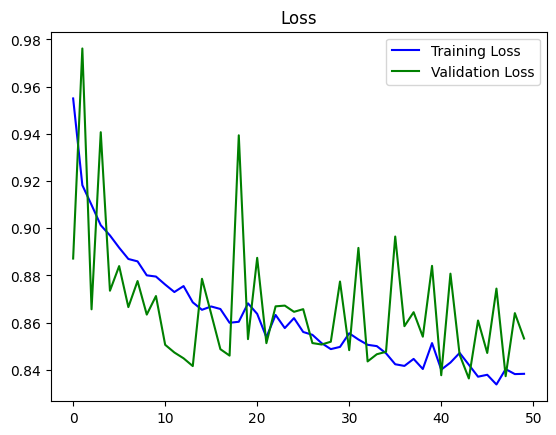

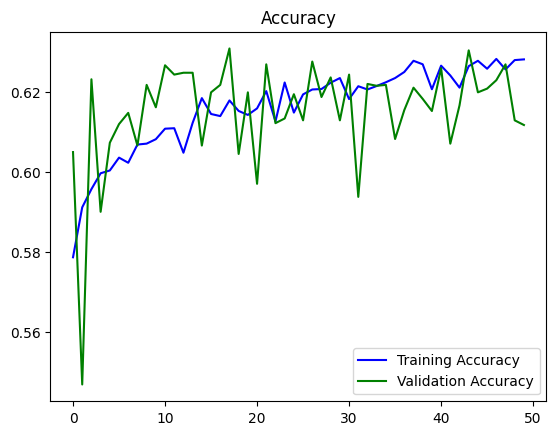

KeyError: 'AUC'

In [260]:
plot_graphs(age_history)

In [261]:
# Defining save path
save_path = r'Probe Classifier\Multilabel\Sex\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on sex metadata
sex_history, sex_trained_classifier = train_probe_classifier(probe_model=sex_compiled_classifier,
                                                             train_features=sex_train_features,
                                                             train_labels=sex_train_df,
                                                             test_features=sex_test_features,
                                                             test_labels=sex_test_df,
                                                             save_path=save_path)

Epoch 1/50
531/535 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - AUC: 0.6561 - Accuracy: 0.6083 - loss: 0.6527
Epoch 1: val_Accuracy improved from -inf to 0.65404, saving model to Probe Classifier\Multilabel\Sex\50_epochs\Weights\Probe_Classifier_1.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.6564 - Accuracy: 0.6086 - loss: 0.6525 - val_AUC: 0.7335 - val_Accuracy: 0.6540 - val_loss: 0.6192
Epoch 2/50
501/535 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - AUC: 0.7150 - Accuracy: 0.6586 - loss: 0.6211
Epoch 2: val_Accuracy improved from 0.65404 to 0.67064, saving model to Probe Classifier\Multilabel\Sex\50_epochs\Weights\Probe_Classifier_2.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - AUC: 0.7153 - Accuracy: 0.6588 - loss: 0.6209 - val_AUC: 0.7399 - val_Accuracy: 0.6706 - val_loss: 0.6072
Epoch 3/50
491/535 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - AUC: 0.7344 - Accuracy: 0.6734 - loss: 0.6052
Epoch 3: val_Accuracy improved from 0.67064 to 0.68467, saving model to Probe Classifier\Multil

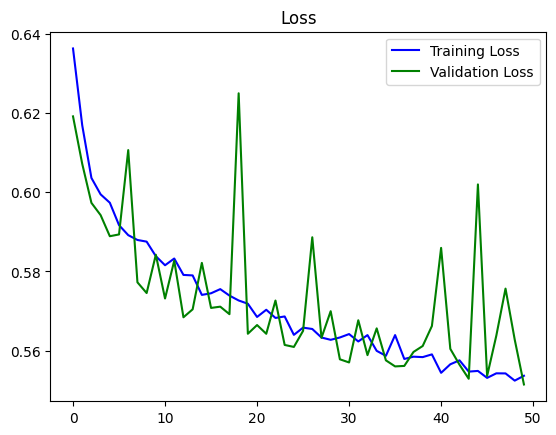

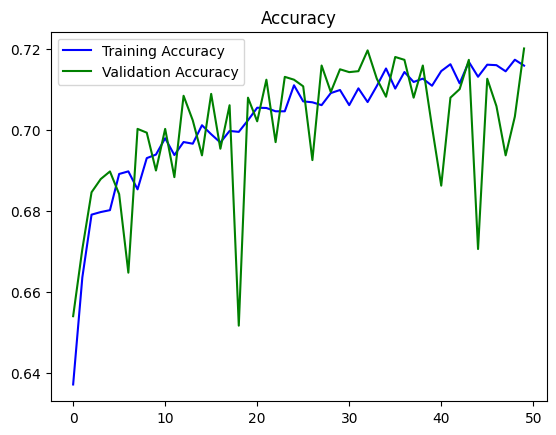

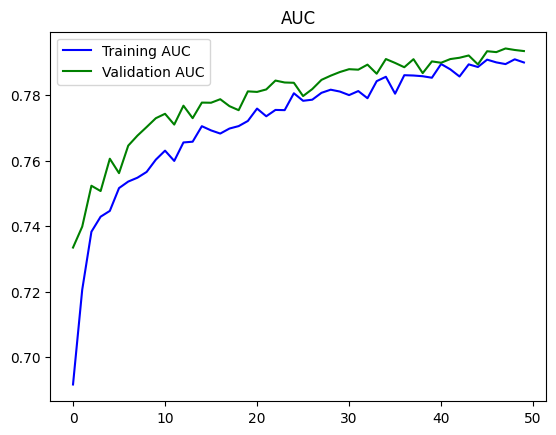

In [262]:
plot_graphs(sex_history)

In [263]:
# Defining save path
save_path = r'Probe Classifier\Multilabel\Height\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on height metadata
height_history, height_trained_classifier = train_probe_classifier(probe_model=height_compiled_classifier,
                                                                   train_features=height_train_features,
                                                                   train_labels=height_train_labels,
                                                                   test_features=height_test_features,
                                                                   test_labels=height_test_labels,
                                                                   save_path=save_path)

Epoch 1/50
130/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5219 - loss: 0.7962
Epoch 1: val_Accuracy improved from -inf to 0.59943, saving model to Probe Classifier\Multilabel\Height\50_epochs\Weights\Probe_Classifier_1.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.5296 - loss: 0.7799 - val_Accuracy: 0.5994 - val_loss: 0.6825
Epoch 2/50
125/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5930 - loss: 0.6912
Epoch 2: val_Accuracy did not improve from 0.59943
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.5915 - loss: 0.6908 - val_Accuracy: 0.5433 - val_loss: 0.7204
Epoch 3/50
134/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.5856 - loss: 0.6940
Epoch 3: val_Accuracy improved from 0.59943 to 0.62145, saving model to Probe Classifier\Multilabel\Height\50_epochs\Weights\Probe_Classifier_3.weights.h5
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.5885 - loss: 0.6923 - val_Accuracy: 0.6214 - val_loss: 0.6648
Epoch 4/50
173/173 ━━━━━━━━━━━━━━

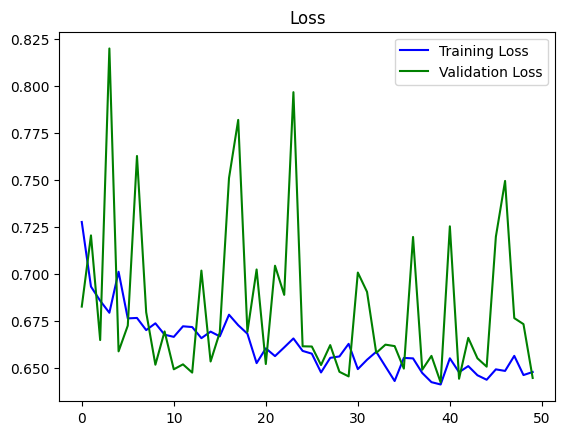

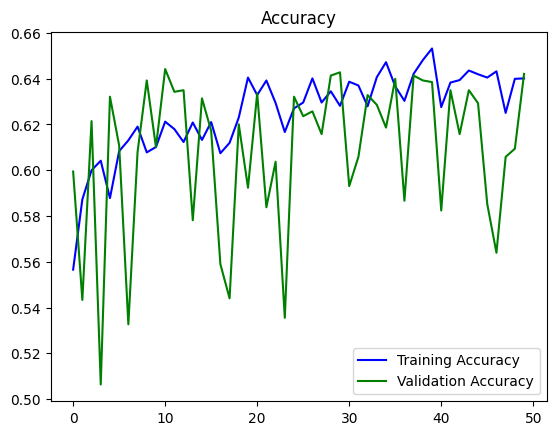

KeyError: 'AUC'

In [264]:
plot_graphs(height_history)

In [265]:
# Defining save path
save_path = r'Probe Classifier\Multilabel\Weight\50_epochs\Weights\Probe_Classifier_{epoch}.weights.h5'

# Training classifier on weight metadata
weight_history, weight_trained_classifier = train_probe_classifier(probe_model=weight_compiled_classifier,
                                                                   train_features=weight_train_features,
                                                                   train_labels=weight_train_labels,
                                                                   test_features=weight_test_features,
                                                                   test_labels=weight_test_labels,
                                                                   save_path=save_path)

Epoch 1/50
202/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.6920 - loss: 0.6839
Epoch 1: val_Accuracy improved from -inf to 0.71963, saving model to Probe Classifier\Multilabel\Weight\50_epochs\Weights\Probe_Classifier_1.weights.h5
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.6950 - loss: 0.6753 - val_Accuracy: 0.7196 - val_loss: 0.6117
Epoch 2/50
226/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.7091 - loss: 0.6062
Epoch 2: val_Accuracy improved from 0.71963 to 0.75054, saving model to Probe Classifier\Multilabel\Weight\50_epochs\Weights\Probe_Classifier_2.weights.h5
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.7095 - loss: 0.6060 - val_Accuracy: 0.7505 - val_loss: 0.5557
Epoch 3/50
222/236 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.7186 - loss: 0.5955
Epoch 3: val_Accuracy improved from 0.75054 to 0.75271, saving model to Probe Classifier\Multilabel\Weight\50_epochs\Weights\Probe_Classifier_3.weights.h5
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Acc

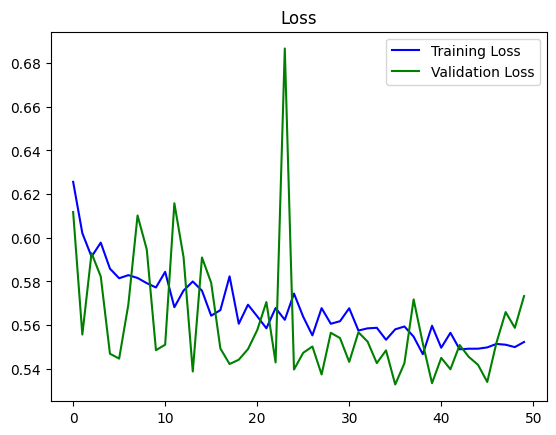

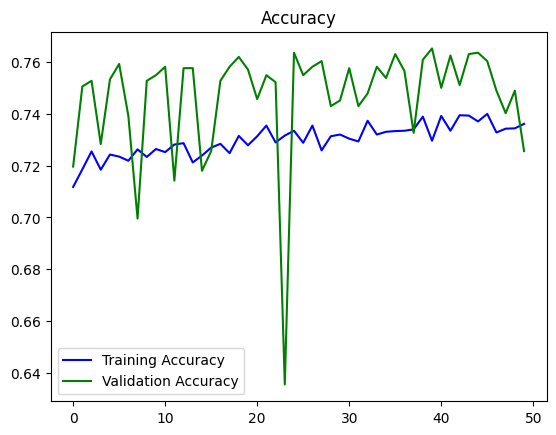

KeyError: 'AUC'

In [266]:
plot_graphs(weight_history)

In [267]:
def get_probe_score(probe_model: keras.Sequential, test_features: np.ndarray, test_labels: np.ndarray) -> list:
    '''
    Returns the loss and accuracy scores of a trained probing classifier.
    
    Args:
        probe_model: The pre-trained probing classifier
        test_features: The feature embeddings used for testing/validation
        test_labels: The labels corresponding the test features
        
    Returns:
        list: A two-element list containing the loss and accuracy of the probing classifier
    '''
    # Ensuring testing labels are in readable format
    test_labels = test_labels.astype('int32')
    
    score = evaluate_model(probe_model, test_features, test_labels)
    return score

In [268]:
age_score = get_probe_score(age_trained_classifier, age_test_features, age_test_labels)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.5966 - loss: 0.8530

Loss on test data: 85.33%

Accuracy on test data: 61.17%


In [269]:
sex_score = get_probe_score(sex_trained_classifier, sex_test_features, sex_test_df)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8023 - Accuracy: 0.7299 - loss: 0.5423

Loss on test data: 55.15%

Accuracy on test data: 72.02%


In [270]:
height_score = get_probe_score(height_trained_classifier, height_test_features, height_test_labels)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.6638 - loss: 0.6361 

Loss on test data: 64.46%

Accuracy on test data: 64.20%


In [271]:
weight_score = get_probe_score(weight_trained_classifier, weight_test_features, weight_test_labels)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Accuracy: 0.7329 - loss: 0.5584  

Loss on test data: 57.33%

Accuracy on test data: 72.56%


<h3>Evaluating Accuracy of Probing Classifier:</h3>

In [277]:
# Loading the best weights for each feature-specific classifier
age_compiled_classifier.load_weights(r'Probe Classifier\Multilabel\Age\50_epochs\Weights\Probe_Classifier_18.weights.h5')

sex_compiled_classifier.load_weights(r'Probe Classifier\Multilabel\Sex\50_epochs\Weights\Probe_Classifier_50.weights.h5')

height_compiled_classifier.load_weights(r'Probe Classifier\Multilabel\Height\50_epochs\Weights\Probe_Classifier_11.weights.h5')

weight_compiled_classifier.load_weights(r'Probe Classifier\Multilabel\Weight\50_epochs\Weights\Probe_Classifier_40.weights.h5')

In [281]:
# Generating predictions for age groups
age_probe_pred = age_compiled_classifier.predict(age_test_features)
age_probe_pred = np.argmax(age_probe_pred, axis=1)
print('\nPredictions:\n', age_probe_pred)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step

Predictions:
 [1 2 2 ... 2 1 2]


In [282]:
age_acc = accuracy_score(age_test_labels, age_probe_pred)
print(f'Age Accuracy Score: {age_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(age_test_labels, age_probe_pred))

Age Accuracy Score: 63.09%

Classification Report:

               precision    recall  f1-score   support

           0       0.53      0.29      0.38       175
           1       0.52      0.47      0.49       884
           2       0.67      0.83      0.74      2414
           3       0.59      0.28      0.38       805

    accuracy                           0.63      4278
   macro avg       0.58      0.47      0.50      4278
weighted avg       0.62      0.63      0.61      4278



In [284]:
# Generating predictions for sex groups
sex_probe_pred = sex_compiled_classifier.predict(sex_test_features)
sex_probe_pred = (sex_probe_pred >= 0.5).astype(int).flatten()
print('\nPredictions:\n', sex_probe_pred)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Predictions:
 [1 1 0 ... 0 0 1]


In [285]:
sex_acc = accuracy_score(sex_test_df, sex_probe_pred)
print(f'Sex Accuracy Score: {sex_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(sex_test_df, sex_probe_pred, target_names=['Male', 'Female']))

Sex Accuracy Score: 72.02%

Classification Report:

               precision    recall  f1-score   support

        Male       0.71      0.79      0.75      2249
      Female       0.73      0.65      0.69      2029

    accuracy                           0.72      4278
   macro avg       0.72      0.72      0.72      4278
weighted avg       0.72      0.72      0.72      4278



In [288]:
# Generating predictions for height groups
height_probe_pred = height_compiled_classifier.predict(height_test_features)
height_probe_pred = np.argmax(height_probe_pred, axis=1)
print('\nPredictions:\n', height_probe_pred)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Predictions:
 [2 3 3 ... 3 3 3]


In [287]:
height_acc = accuracy_score(height_test_labels, height_probe_pred)
print(f'Height Accuracy Score: {height_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(height_test_labels, height_probe_pred))

Height Accuracy Score: 64.42%

Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.63      0.64      0.64       684
           3       0.66      0.65      0.65       721

    accuracy                           0.64      1408
   macro avg       0.32      0.32      0.32      1408
weighted avg       0.64      0.64      0.64      1408



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [289]:
# Generating predictions for weight groups
weight_probe_pred = weight_compiled_classifier.predict(weight_test_features)
weight_probe_pred = np.argmax(weight_probe_pred, axis=1)
print('\nPredictions:\n', weight_probe_pred)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Predictions:
 [1 1 1 ... 1 1 1]


In [290]:
weight_acc = accuracy_score(weight_test_labels, weight_probe_pred)
print(f'Weight Accuracy Score: {weight_acc:.2%}\n')
print('Classification Report:\n\n', classification_report(weight_test_labels, weight_probe_pred))

Weight Accuracy Score: 76.52%

Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.21      0.31       455
           1       0.78      0.96      0.86      1379
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         1

    accuracy                           0.77      1844
   macro avg       0.35      0.29      0.29      1844
weighted avg       0.73      0.77      0.72      1844



c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\loera\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo